# Customer Purchase Profile

The following example is using generated sample data based on Amazon purchase data.

## Table of Contents
 - How to retrieve your data

 - 3 Data Prep
     - 3.1 Imports
     - 3.2 Anonymization
     - 3.3 Cleaning
     - 3.4 (Saving & Re-importing)

 - 4 Data Insights
     - 4.1 At-a-Glance insights. - Insights at a glance(Categories, visualizing simple segmentations, Averages, values over time, etc.)
     - 4.2 In-depth Insights - Insights in depth (Complex Data Processing, Custom Segmentations, Visualizations of Complex Processing, Machine Learning, etc.)
 - 5 Further Future Steps

## 2 Data Retrieval:
 - **Step 1.)** Go to [this page](https://www.amazon.com/gp/b2b/reports?ref_=ya_d_l_order_reports&). (If the link doesn't work then go to your account and click on the link that says "Download order reports" under the section titled "Ordering and shopping preferences".)

 - **Step 2.)** Under "Report Type" the selection "Items" should already be selected.  For the Start Date select January 1st of the lowest numerical year.  Click on "use today" on the next line.  Feel free to title the report whatever helps you remember it.  (This isn't information that I'll be able to see anyways.)

 - **Step 3.)** Click on "Request Report".  Then send me the accompanying csv file in whatever way is easiest for you or is standard for the company.

 - **Step 4.)** If you'd like to do even more then you can also select the other three choices under "Report Type" and send me the reports by repeating steps 2 and 3 for each.  (Note: Orders and Shipments is mostly data that's already covered in the item csv, but with the difference that items rows have been combined into the individual box in which they've been shipped and it includes the shipping price and promotion info of the whole shipment.)

## 3 Data Prep

### 3.1 Importing Data

In [1]:
# [Code for importing data and libraries.]
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Natural Language Processing libraries
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
# Other
import requests
import time
import re

In [2]:
my_data = pd.read_csv('./data/Example_data.csv')

### 3.3 Data Cleaning & Transformation

In [3]:
def funct_price_to_int(Series):
    return Series.map(lambda x: float(x.strip('$')))

def funct_percent_of_total_col(column, interesting_value):
    return ((column == interesting_value)*1).sum() / len(column.dropna())

def funct_prep_data_items(df_for_function):
    df_for_function = df_for_function.rename(
            {'List Price Per Unit'     : 'Price_listed',
            'Purchase Price Per Unit' : 'Price_purchased_at',
            'Payment Instrument Type' : 'Payment_type',
            'Order Date'              : 'Order_date',
            'Item Subtotal Tax'       : 'Tax'
            }, axis = 1)
    df_for_function = df_for_function[['Order_date', 'Title', 'Category', 
                                       'Condition',
                                       'Seller', 
                                       'Price_listed',
                                       'Price_purchased_at', 
                                       'Quantity', 
                                       #'Payment_type', 
                                       'Tax']]
    
    for col in ['Price_listed', 'Price_purchased_at', 'Tax']:
        df_for_function[col] = funct_price_to_int(df_for_function[col])
    df_for_function['Category'] = df_for_function['Category'].fillna("Uncategorized")
    df_for_function['Seller']   = df_for_function['Seller'].fillna("No_seller_listed")
    df_for_function['Condition']   = df_for_function['Condition'
        ].fillna("Pre_Condition_listing")
    
    print("Nulls in DF: ", df_for_function.isna().sum().sum())
    return df_for_function

def funct_items_to_day(Org_df, Org_series_name  = 'Order_date'):
    list_of_dicts   = []

    for Org_Foc_unique_value in list(Org_df[Org_series_name].unique()):
        mask        = Org_df[Org_series_name] == Org_Foc_unique_value
        sub_df          = Org_df[mask]

        list_of_dicts.append({
            'Order_date'         : Org_Foc_unique_value,
            'Sum_price_listed'   : sub_df['Price_listed'].sum(),
            'Sum_price_purchased': sub_df['Price_purchased_at'].sum(),
            'Sum_tax'            : sub_df['Tax'].sum(),
            'Num_items'          : sub_df['Quantity'].sum()})
    Fnl_df = pd.DataFrame(list_of_dicts)

    # The rest of this is just cleaning the DF
    for index in Fnl_df.index:
        cell_value = Fnl_df.loc[index,'Order_date']
        Fnl_df.loc[index,'Month'] = int(cell_value[:2])
        Fnl_df.loc[index,'Day']   = int(cell_value[3:5])
        Fnl_df.loc[index,'Year']  = int(cell_value[6:8]) + 2000

    # Floats to Intigers
    Fnl_df['Day']   = Fnl_df['Day'].map(lambda x: int(x))
    Fnl_df['Month'] = Fnl_df['Month'].map(lambda x: int(x))
    Fnl_df['Year']  = Fnl_df['Year'].map(lambda x: int(x))
    Fnl_df = pd.DataFrame(Fnl_df, columns=['Order_date','Month', 'Day', 'Year', 
                                           'Num_items', 'Sum_price_listed', 
                                         'Sum_price_purchased', 'Sum_tax'])
    Fnl_df['date_sorted'] = pd.to_datetime(Fnl_df['Order_date'])
    Fnl_df = Fnl_df.sort_values('date_sorted').reset_index(drop = True).drop(
        'date_sorted', axis = 1)
    return Fnl_df




#df = funct_items_to_day(funct_prep_data_items(df_1_items))

def funct_day_to_month(org_df):
    df_by_month = pd.DataFrame(columns=['Month','Num_items',
           'Sum_price_listed', 'Sum_price_purchased', 'Sum_tax'])
    
    for month in [i for i in range(1,13)]:
        mask   = (org_df['Month'] == month)
        sub_df = org_df[mask]
        
        df_by_month = df_by_month.append({
            'Month'               : str(dict_months[month]),
            'Month_num'           : int(month),
            'Num_items'           : sub_df['Num_items'].sum(),
            'Sum_price_listed'    : sub_df['Sum_price_listed'].sum(),
            'Sum_price_purchased' : sub_df['Sum_price_purchased'].sum(),
            'Sum_tax'             : sub_df['Sum_tax'].sum(),
            'Sum_total_spent'     : (sub_df['Sum_tax'].sum() + 
                                     sub_df['Sum_price_purchased'].sum()),
            'Sum_untaxed_saved'   : (sub_df['Sum_price_listed'].sum() - 
                                     sub_df['Sum_price_purchased'].sum())
            }, ignore_index = True)
        
    df_by_month.set_index(df_by_month['Month'], inplace=True)
    del df_by_month.index.name
    return df_by_month.drop('Month', axis = 1)
#funct_day_to_month(client1['dayby'])

import calendar
dict_months = {k: v for k,v in enumerate(calendar.month_abbr)}

def funct_day_to_month_and_year(org_df):
    df_by_month = pd.DataFrame(columns=['Month','Num_items',
           'Sum_price_listed', 'Sum_price_purchased', 'Sum_tax'])
            
    for year in [i for i in range(org_df['Year'].unique()[0],
                                  org_df['Year'].unique()[-1])]:
        for month in range(1,13):
            mask   = (org_df['Year'] == year) &(org_df['Month'] == month)
            sub_df = org_df[mask]
            df_by_month = df_by_month.append({'Month' : (str(dict_months[month]) 
                                                        + " '" + str(year)[2:]),
             'Month_num' : int(month),
             'Num_items' : sub_df['Num_items'].sum(),
             'Sum_price_listed' : sub_df['Sum_price_listed'].sum(),
             'Sum_price_purchased' : sub_df['Sum_price_purchased'].sum(),
             'Sum_tax' : sub_df['Sum_tax'].sum()}, ignore_index = True)
    df_by_month.set_index('Month', inplace=True)
    del df_by_month.index.name
    return df_by_month


def funct_day_to_year(org_df):
    df_by_year = pd.DataFrame(columns=['Year','Num_items',
           'Sum_price_listed', 'Sum_price_purchased', 'Sum_tax'])
    
    for year in [i for i in range(org_df['Year'].unique()[0],
                                  org_df['Year'].unique()[-1] + 1)]:
        mask   = (org_df['Year'] == year)
        sub_df = org_df[mask]
        df_by_year = df_by_year.append({'Year' : int(year),
            'Num_items'           : sub_df['Num_items'].sum(),
            'Sum_price_listed'    : sub_df['Sum_price_listed'].sum(),
            'Sum_price_purchased' : sub_df['Sum_price_purchased'].sum(),
            'Sum_tax'             : sub_df['Sum_tax'].sum(),
            'Sum_total_spent'     : (sub_df['Sum_tax'].sum() + 
                sub_df['Sum_price_purchased'].sum()),
            'Sum_untaxed_saved'   : (sub_df['Sum_price_listed'].sum() 
                - sub_df['Sum_price_purchased'].sum())                             
                }, ignore_index = True)
    df_by_year.set_index(df_by_year['Year'].map(lambda x: int(x)), inplace=True)
    del df_by_year.index.name
    return df_by_year.drop('Year', axis = 1)
#funct_day_to_year(client1['dayby'])

def funct_items_by_category(org_df):
    list_of_dicts   = []
    
    for cat in org_df['Category'].fillna('None').sort_values().unique():
        mask = org_df['Category'] == cat
        sub_df = org_df[mask]
        
        list_of_dicts.append({
            'Category'           : cat,
            'Percent_new'        : int((np.round(funct_percent_of_total_col(
                sub_df['Condition'], 'new'),3)) * 100),
            'Sum_price_listed'   : sub_df['Price_listed'].sum(),
            'Sum_price_purchased': sub_df['Price_purchased_at'].sum(),
            'Sum_tax'            : sub_df['Tax'].sum(),
            'Num_items'          : sub_df['Quantity'].sum()
        })
        
        
        df_new = pd.DataFrame(list_of_dicts).dropna()
        df_new.set_index('Category', inplace = True)
        del df_new.index.name
        
    # The following comments are things I tried to have in-funt, but didn't work
        #df_new = funct_summarize_rows(df_new)
        #df_new['Num_items'] = df_new['Num_items'].map(lambda x: int(x))
    return df_new
#funct_items_by_category(client1['items'])

def funct_summarize_rows(df, 
    row_new   = 'Books', 
    rows_old  = ['Hardcover','Paperback','Spiral-bound','Unknown Binding']
):
    rows_old  = [ i for i in df.index if i in rows_old]
    sub_df    = df.loc[rows_old,:].dropna()
    dict_book = {}
    
    for col in sub_df.drop('Percent_new', axis = 1).columns:
        dict_book[col] = np.round(sub_df[col].sum(), 3)
    dict_book['Percent_new'] = np.average(sub_df['Percent_new'])
    return df.append(pd.Series(dict_book).rename(row_new)
            ).drop(rows_old, errors = 'ignore'
            ).sort_index()
#funct_summarize_rows(funct_items_by_category(client1['items']))

## 3.4 Importing Data

In [4]:
df_items        = funct_prep_data_items(my_data)
df_day          = funct_items_to_day(df_items)
df_month        = funct_day_to_month(df_day)
df_month_year   = funct_day_to_month_and_year(df_day)
df_year         = funct_day_to_year(df_day)
df_category     = funct_summarize_rows(funct_items_by_category(df_items)
                                      ).sort_values('Num_items', ascending = False)

#df_category['Num_items'] = client3['Category']['Num_items'].map(lambda x: int(x))

Nulls in DF:  0


## 4 Insights 

### 4.1 At-A-Glance Insights.
Simple and/or quick insights for the Individual profile at a glance.

In [5]:
# [Code for the simple data insights.]

In [6]:
# df_category #2
# Total amount saved (Tax not involved)

round(df_category['Sum_price_listed'].sum() - 
      df_category['Sum_price_purchased'].sum(), 3)

1398.67

In [7]:
# df_category #3
# Percent saved (Tax not involved)

round(1 - df_category['Sum_price_purchased'].sum() / 
      df_category['Sum_price_listed'].sum(), 3)

0.424

In [10]:
# % New
np.round(funct_percent_of_total_col(df_items['Condition'],'new'),2)

0.82

In [11]:
# Stat_%_of_col 3
# Percent of sellers that weren't Amazon
print(1 - funct_percent_of_total_col(df_items,'Amazon.com'))
# [Needs to be cleaned by removing the other columns and fixing the notice.]

Order_date            1.00
Title                 1.00
Category              1.00
Condition             1.00
Seller                0.75
Price_listed          1.00
Price_purchased_at    1.00
Quantity              1.00
Tax                   1.00
dtype: float64


/Users/pearl/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Categories

In [12]:
# df_category #2
# Top 10 catagories
df_category.head(10)

,Percent_new,Sum_price_listed,Sum_price_purchased,Sum_tax,Num_items
Uncategorized,100.0,221.92,249.31,6.18,20.0
Books,30.0,1462.97,462.82,13.12,14.0
Personal Computers,92.0,512.50,354.41,21.05,14.0
Video Game,22.0,239.91,58.60,4.88,9.0
Electronics,100.0,62.95,80.10,1.76,7.0
Misc.,100.0,204.91,157.31,5.64,7.0
Office Product,100.0,96.97,97.08,3.33,7.0
Kitchen,100.0,62.98,103.67,6.04,5.0
Tools & Home Improvement,100.0,98.45,47.94,4.64,5.0
Wireless Phone Accessory,100.0,69.95,83.91,0.00,4.0


### Top Words

In [13]:

def preprocess(text):
    text = re.sub(r'[^a-zA-Z]',' ', text.lower())
    tokens = word_tokenize(text)
    lemmer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    return " ".join([lemmer.lemmatize(word) for word 
                     in tokens if len(word) > 1 and not word in stop_words])
cvec = CountVectorizer(analyzer = "word",
                       min_df = 2,
                       preprocessor = preprocess,
                       stop_words = 'english')

In [14]:
# NLP 2
def funct_df_to_word_count(df_funct):
    df_cvec = pd.DataFrame(cvec.fit_transform(df_funct['Title'
        ].map(lambda x: preprocess(x))).todense(),
        columns=cvec.get_feature_names())
    list_of_dicts = []
    for row_name in df_cvec.columns:
        list_of_dicts.append({
            'Word'  : row_name,
            'Count' : df_cvec[row_name].sum()
        })
    return pd.DataFrame(list_of_dicts, columns= ['Word', 'Count']
                       ).sort_values(by = 'Count',ascending=False
                       ).reset_index().drop('index',axis = 1)

In [15]:
# NLP 3
df_word_count = funct_df_to_word_count(df_items)
df_word_count.index += 1 
df_word_count.head(15)

/Users/pearl/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,Word,Count
1,black,22
2,dance,14
3,pack,12
4,usb,11
5,cable,11
6,pc,8
7,lens,8
8,revolution,7
9,playstation,7
10,case,7


## Graphs

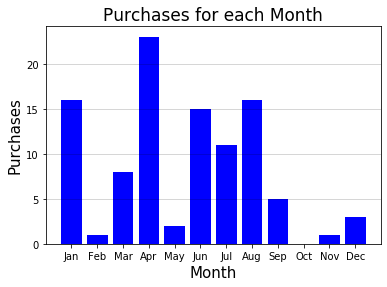

In [16]:
# Graph 1
# Count per Month
plt.bar(df_month.index,                  # X Positions
         df_month['Num_items'], color = 'blue')          # Bar Heights

# X axis
plt.xlabel("Month", size = 15)

# Y axis
plt.grid(   axis = 'y', alpha = 0.2, color = 'black')
plt.ylabel( "Purchases", size = 15)

# Meta
plt.title("Purchases for each Month", size = 17);

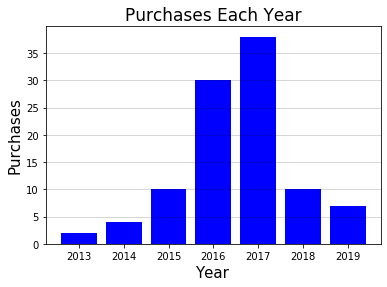

In [17]:
# Graph 2: Count / Year
plt.bar(df_year.index,                  # X Positions
        df_year['Num_items'], color = 'blue')          # Bar Heights

# X axis
plt.xlabel("Year", size = 15)
#plt.xticks([2018])#[i for i in range(2006,2020)])


# Y axis
plt.grid(   axis = 'y', alpha = 0.2, color = 'black')
plt.ylabel( "Purchases", size = 15)

# Meta
plt.title("Purchases Each Year", size = 17);

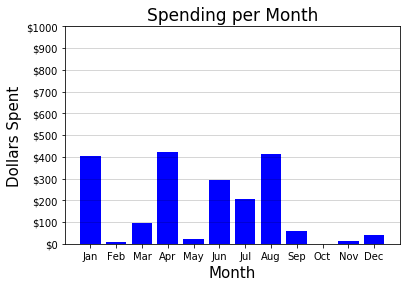

In [18]:
# Graph 3: $ / Month
plt.bar(df_month.index,                  # X Positions
         df_month['Sum_total_spent'], color = 'blue')          # Bar Heights

 # X axis
plt.xlabel("Month", size = 15)

# Y axis
val_range = range(0,1001,100)
#val_range = range(0,801,100)
plt.yticks(   ticks = [i for i in val_range], labels = ['$' + str(i) for i in val_range])
plt.grid(     axis = 'y', alpha = 0.2, color = 'black')
plt.ylabel(   "Dollars Spent", size = 15)


# Meta
plt.title("Spending per Month", size = 17);

In [19]:
df_year

,Num_items,Sum_price_listed,Sum_price_purchased,Sum_tax,Sum_total_spent,Sum_untaxed_saved
2013,2.0,27.00,63.28,5.54,68.82,-36.28
2014,4.0,225.59,41.29,0.00,41.29,184.30
2015,10.0,615.78,187.36,11.90,199.26,428.42
2016,30.0,1289.50,637.00,14.34,651.34,652.50
2017,38.0,896.07,669.08,35.51,704.59,226.99
2018,10.0,147.96,183.94,9.16,193.10,-35.98
2019,7.0,96.52,117.80,0.00,117.80,-21.28


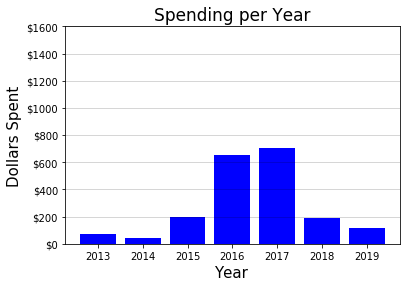

In [20]:
# Graph 4: $/Year
plt.grid(axis = 'y', alpha = 0.2, color = 'black')
plt.bar(df_year.index,                  # X Positions
         df_year['Sum_total_spent'], color = 'blue')    # Bar Heights
plt.xlabel("Year", size = 15)

plt.ylabel("Dollars Spent", size = 15)
val_range = range(0,1601,200)
#val_range = range(0,2501,250)
plt.yticks(ticks= [i for i in val_range], labels = ['$' + str(i) for i in val_range])

plt.title("Spending per Year", size = 17);

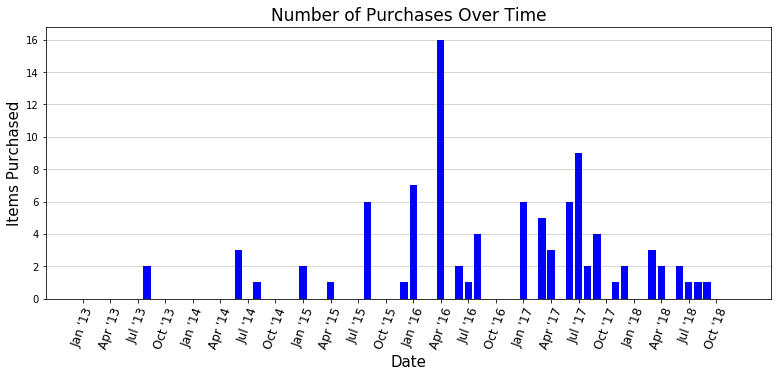

In [21]:
# Graph 6

# Pre-Meta
plt.figure(figsize=(13,5))

# Plot Type
plt.bar(df_month_year.index.values,
         (df_month_year['Num_items']),
         color='blue')

# X axes
plt.xlabel("Date", size = 15)
plt.xticks(range(0,df_month_year.shape[0], 3),rotation=70, fontsize=12);

# Y axes
plt.ylabel("Items Purchased", size = 15)
plt.grid(   axis = 'y', alpha = 0.2, color = 'black')

# Post Meta
plt.title("Number of Purchases Over Time", size = 17);

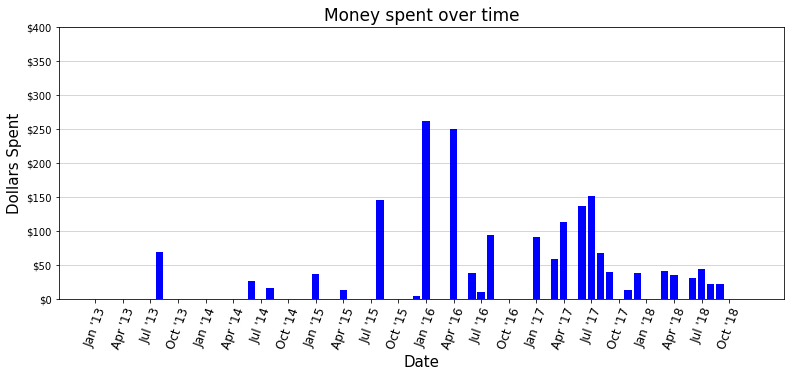

In [22]:
# Graph 5: $ Spent every month

# Pre Meta
plt.figure(figsize=(13,5))

# Plot Type
plt.bar(df_month_year.index.values,
         (df_month_year['Sum_price_purchased'] + df_month_year['Sum_tax']),
         color='b')

# X axes
plt.xlabel("Date", size = 15)
plt.xticks(range(0,df_month_year.shape[0], 3),rotation=70, fontsize=12)

# Y axes
val_range = range(0,401,50)
#val_range = range(0,701,100)
plt.yticks(ticks= [i for i in val_range], labels = ['$' + str(i) for i in val_range])
plt.ylabel("Dollars Spent", size = 15)
plt.grid(   axis = 'y', alpha = 0.2, color = 'black')


# Post Meta
plt.title("Money spent over time", size = 17);

# calculate x scale